## Import Libraries

- requirements.txt
    - jupyterlab==4.0.8
    - darts==0.27.0
    - pandas==1.2.3
    - plotly==5.18.0
    - nbformat==5.9.2
    - ipywidgets


In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller
from tqdm import tqdm

## Read and Preprocess data
https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [3]:
path = 'data/store-sales-time-series-forecasting'
data = pd.read_csv(path + '/train.csv', delimiter=",")
holidays= pd.read_csv(path + '/holidays_events.csv', delimiter=",").drop('type', axis=1)
stores= pd.read_csv(path + '/stores.csv', delimiter=",")
transactions= pd.read_csv(path + '/transactions.csv', delimiter=",")
holidays['holiday_flag']=1
data = data.merge(holidays, on='date', how='left')
data= data.merge(stores, on='store_nbr', how='left')
data = data[data['date']!='2013-01-01'] # Bad data
data= data.merge(transactions, on=['date', 'store_nbr'], how='left')
data['date'] = pd.to_datetime(data["date"])
data = data.drop_duplicates(subset=['date','store_nbr', 'family'], keep='last')
data.loc[data['holiday_flag'].isna(),'holiday_flag']=0
data['year'] = data['date'].dt.year 
data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'locale',
       'locale_name', 'description', 'transferred', 'holiday_flag', 'city',
       'state', 'type', 'cluster', 'transactions', 'year'],
      dtype='object')

In [4]:
data.groupby('store_nbr')['sales'].agg(['count','sum']).sort_values(by='sum',ascending=False).head()
# Store_nbr: 44, 45, 47, 3 are large stores. We will just do the forecasting for them.
data.groupby('family')['sales'].agg(['count','sum']).sort_values(by='sum',ascending=False).head()
# Product family: 'GROCERY I','BEVERAGES','PRODUCE','CLEANING' are large categories. We will just do the forecasting for them.

,count,sum
family,,
GROCERY I,90882,3.434620e+08
BEVERAGES,90882,2.169537e+08
PRODUCE,90882,1.227047e+08
CLEANING,90882,9.752110e+07
DAIRY,90882,6.448757e+07


In [5]:
data = data[ ( data['store_nbr'].isin([44, 45, 47, 3]) ) & 
             ( data['family'].isin(['GROCERY I','BEVERAGES','PRODUCE','CLEANING']) ) &
             ( data['date'].dt.year >=2016)
           ]

In [6]:
# Split data into train and test
train = data[data['date']<pd.to_datetime('2017-07-15')]
test = data[data['date']>=pd.to_datetime('2017-07-15')]

In [7]:
[train['date'].nunique(),test['date'].nunique()]

[560, 32]

In [8]:
TIME_COL = "date"
TARGET = "sales"
STATIC_COV = ['store_nbr', 'family'] 
FREQ = "D"
FORECAST_HORIZON = test['date'].nunique() 
COVARIATES = ['onpromotion','holiday_flag']
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

In [9]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'locale',
       'locale_name', 'description', 'transferred', 'holiday_flag', 'city',
       'state', 'type', 'cluster', 'transactions', 'year'],
      dtype='object')

## Tranform data into Darts format

In [10]:
# read train and test datasets and transform train dataset
train_darts = TimeSeries.from_group_dataframe(df=train, 
                                              group_cols=STATIC_COV, 
                                              time_col=TIME_COL, 
                                              value_cols=TARGET, 
                                              freq=FREQ, 
                                              fill_missing_dates=True, 
                                              fillna_value=0)
test_darts = TimeSeries.from_group_dataframe(df=test, 
                                             group_cols=STATIC_COV, 
                                             time_col=TIME_COL, 
                                             value_cols=TARGET, 
                                             freq=FREQ, 
                                             fill_missing_dates=True, 
                                             fillna_value=0)

In [11]:
[len(train_darts[0]), len(test_darts[0])]

[561, 32]

## Create Covariates

In [12]:
create_covariates = []
for ts in train_darts:
    # Add the month and week as a covariate
    covariate = datetime_attribute_timeseries(
        ts,
        attribute="month",
        one_hot=True,
        cyclic=False,
        add_length=FORECAST_HORIZON,
    )
    covariate = covariate.stack(
        datetime_attribute_timeseries(
            ts,
            attribute="week",
            one_hot=True,
            cyclic=False,
            add_length=FORECAST_HORIZON,
        )
    )
    store = ts.static_covariates['store_nbr'].item()
    family = ts.static_covariates['family'].item()
    # create covariates to fill with interpolation
    other_cov = TimeSeries.from_dataframe(data[(data['store_nbr'] == store) & (data['family'] == family)], time_col=TIME_COL, value_cols=COVARIATES, freq=FREQ, fill_missing_dates=True)
    covariate = covariate.stack(MissingValuesFiller().transform(other_cov))

    create_covariates.append(covariate)

In [13]:
len(create_covariates)

16

In [14]:
create_covariates[0].columns

Index(['month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'week_0', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6',
       'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12',
       'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18',
       'week_19', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24',
       'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30',
       'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36',
       'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42',
       'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48',
       'week_49', 'week_50', 'week_51', 'onpromotion', 'holiday_flag'],
      dtype='object', name='component')

In [15]:
TimeSeries.pd_dataframe(create_covariates[0]).tail()

component,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,onpromotion,holiday_flag
time,,,,,,,,,,,,,,,,,,,,,
2017-08-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0
2017-08-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
2017-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0
2017-08-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0
2017-08-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,1.0


In [16]:
TimeSeries.pd_dataframe(train_darts[15]).tail()

component,sales
date,
2017-07-10,5062.7570
2017-07-11,4450.1978
2017-07-12,6675.8190
2017-07-13,4157.3610
2017-07-14,4637.2200


## Transform Data

In [17]:
# scale data and transform static covariates
# Notice SCALER is before PIPELINE because PIPELINE includes SCALER
covariates_transformed = SCALER.fit_transform(create_covariates)
train_transformed = PIPELINE.fit_transform(train_darts)

In [18]:
train_transformed[0].columns

Index(['sales'], dtype='object', name='component')

In [19]:
covariates_transformed[0].columns

Index(['month_0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'week_0', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6',
       'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12',
       'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18',
       'week_19', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24',
       'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30',
       'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36',
       'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42',
       'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48',
       'week_49', 'week_50', 'week_51', 'onpromotion', 'holiday_flag'],
      dtype='object', name='component')

In [20]:
TimeSeries.pd_dataframe(covariates_transformed[0]) # 143 weeks from 2010-02-05 to 2012-10-26

component,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,onpromotion,holiday_flag
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0
2016-01-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041237,0.0
2016-01-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020619,0.0
2016-01-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041237,0.0
2016-01-05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041237,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134021,1.0
2017-08-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123711,0.0
2017-08-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134021,0.0


In [21]:
[len(covariates_transformed[0]), len(train_transformed[0])]

[593, 561]

## TFT

In [22]:
TFT_params = {
    "input_chunk_length": 52, 
    "output_chunk_length": FORECAST_HORIZON,
    "hidden_size": 2,
    "lstm_layers": 2,
    "num_attention_heads": 1,
    "dropout": 0.1,
    "batch_size": 16,
    "n_epochs": 3,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 1e-3},
}

tft_model = TFTModel(**TFT_params)
tft_model.fit(train_transformed, # The training periods
              future_covariates=covariates_transformed, # The entire periods
              verbose=False)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/chriskuo/anaconda3/envs/time_series/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/chriskuo/anaconda3/envs/time_series/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
`Trainer.fit` stopped: `max_epochs=3` reached.


TFTModel(output_chunk_shift=0, hidden_size=2, lstm_layers=2, num_attention_heads=1, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=52, output_chunk_length=32, batch_size=16, n_epochs=3, random_state=42, optimizer_kwargs={'lr': 0.001})

In [23]:
# Get the prediction that is scaled
scaled_pred = tft_model.predict(n=FORECAST_HORIZON, 
                                series=train_transformed, # The training periods
                                num_samples=50, 
                                future_covariates=covariates_transformed # The entire periods
                               )


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


In [24]:
len(scaled_pred[0])

32

In [25]:

# Transform the scaled prediction to the normal scale
prediction = PIPELINE.inverse_transform(scaled_pred)

### Plotting

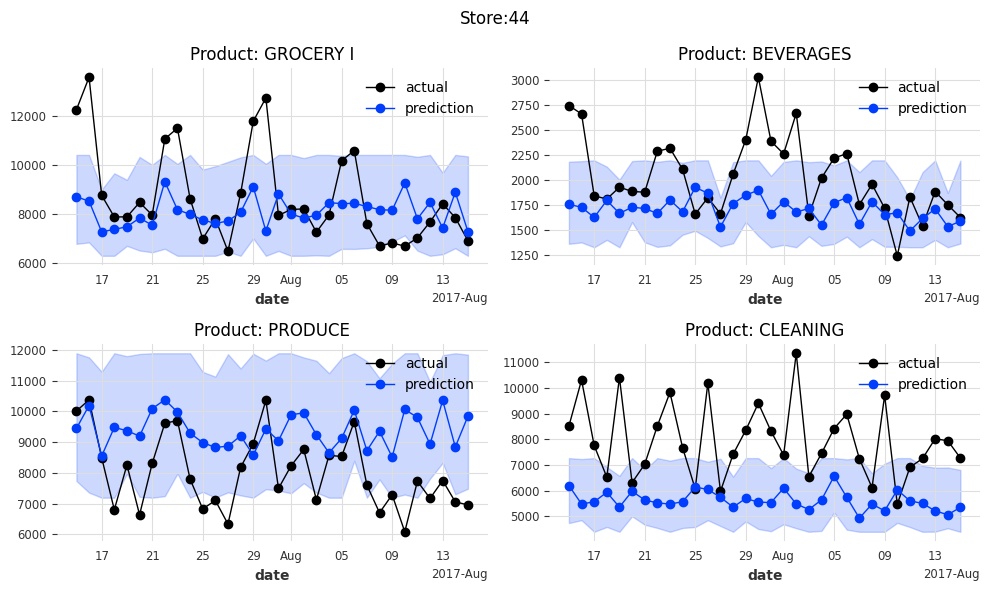

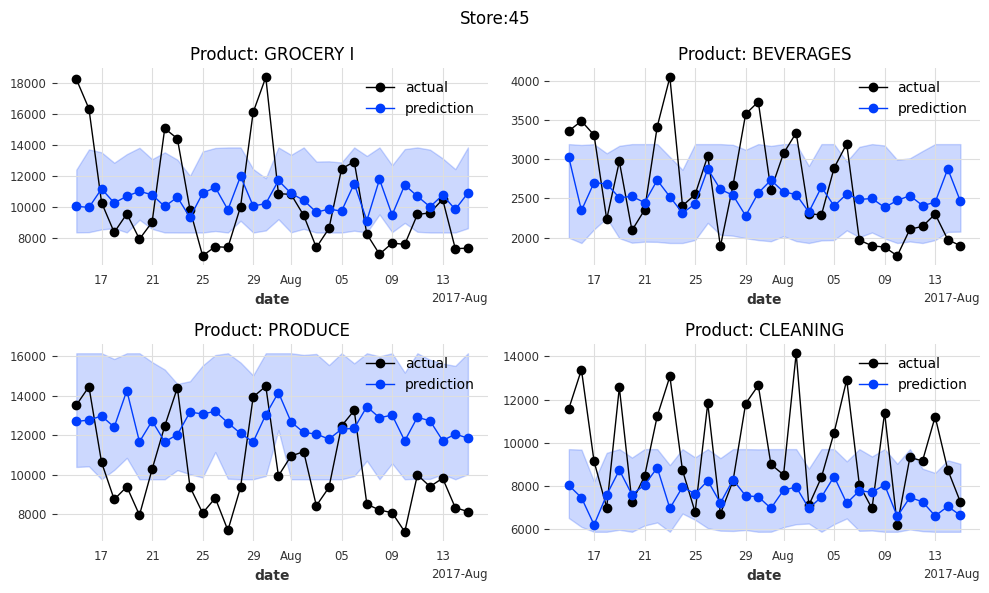

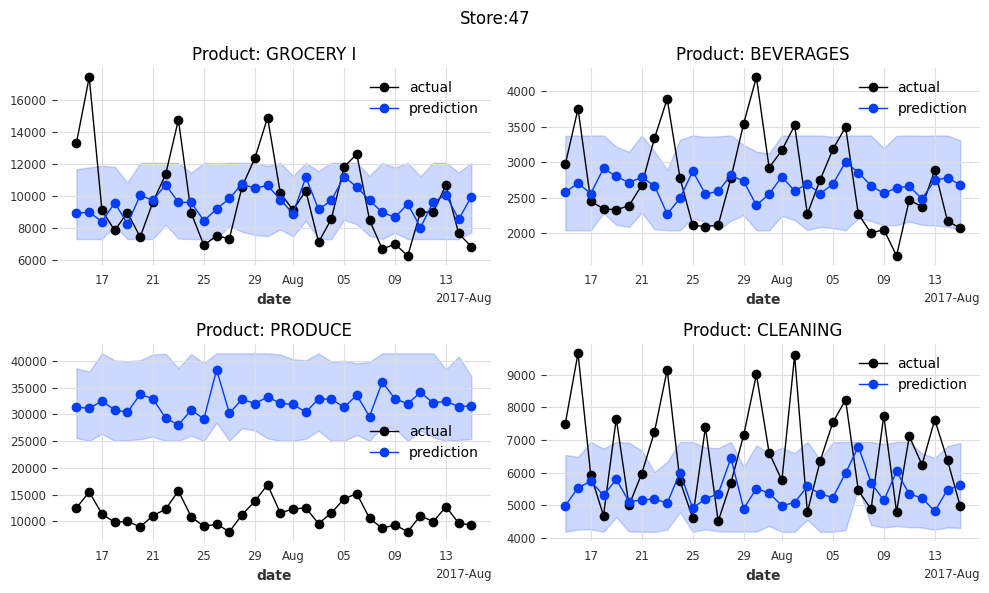

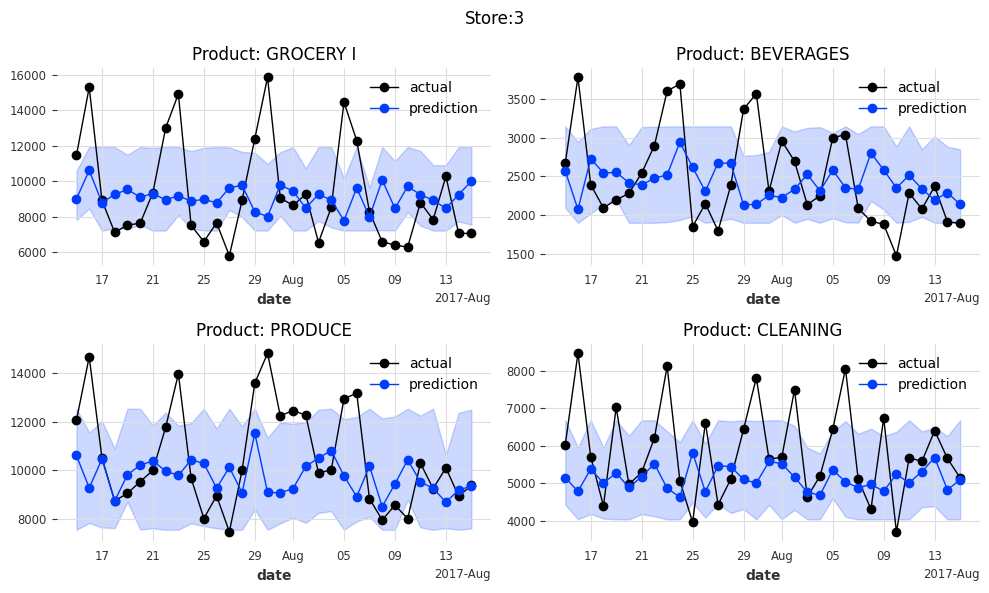

In [26]:
def plot_it():
    fig, axs = plt.subplots(2, 2, figsize=(10, 6), dpi=100)
    ax0 = axs[0,0]
    ax1 = axs[0,1]
    ax2 = axs[1,0]
    ax3 = axs[1,1]
    
    plt.suptitle("Store:" +  str(store) , fontsize=12)
    
    val0[: pred0.end_time()].plot(ax=ax0, label="actual", marker='o', linewidth=1)
    pred0.plot(ax = ax0, low_quantile=0.25, high_quantile=0.75, label="prediction", marker='o',linewidth=1,alpha=0.2 )
    ax0.title.set_text('Product: '+family[0])
    
    val1[: pred1.end_time()].plot(ax=ax1, label="actual", marker='o', linewidth=1)
    pred1.plot(ax = ax1, low_quantile=0.25, high_quantile=0.75, label="prediction", marker='o',linewidth=1,alpha=0.2 )
    ax1.title.set_text('Product: '+family[1])
    
    val2[: pred2.end_time()].plot(ax=ax2, label="actual", marker='o', linewidth=1)
    pred2.plot(ax = ax2, low_quantile=0.25, high_quantile=0.75, label="prediction", marker='o',linewidth=1,alpha=0.2 )
    ax2.title.set_text('Product: '+family[2])
    
    val3[: pred3.end_time()].plot(ax=ax3, label="actual", marker='o', linewidth=1)
    pred3.plot(ax = ax3, low_quantile=0.25, high_quantile=0.75, label="prediction", marker='o',linewidth=1,alpha=0.2 )
    ax3.title.set_text('Product: '+family[3])
    fig.tight_layout()
    plt.show()


store_nbr = [44, 45, 47, 3]
family = ['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING']

for i in range(0,16,4):
    k = int(i/4)
    store = store_nbr[k]
    pred0 = prediction[i]
    pred1 = prediction[i+1]
    pred2 = prediction[i+2]
    pred3 = prediction[i+3]
    val0 = test_darts[i]
    val1 = test_darts[i+1]
    val2 = test_darts[i+2]
    val3 = test_darts[i+3]
    plot_it()

## Explainability

In [28]:
from darts.explainability import TFTExplainer

explainer = TFTExplainer(
    tft_model,
    background_series=train_transformed[1],
    background_future_covariates=covariates_transformed[1],
)
explainability_result = explainer.explain()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/chriskuo/anaconda3/envs/time_series/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.02it/s]


### Encoder Importance

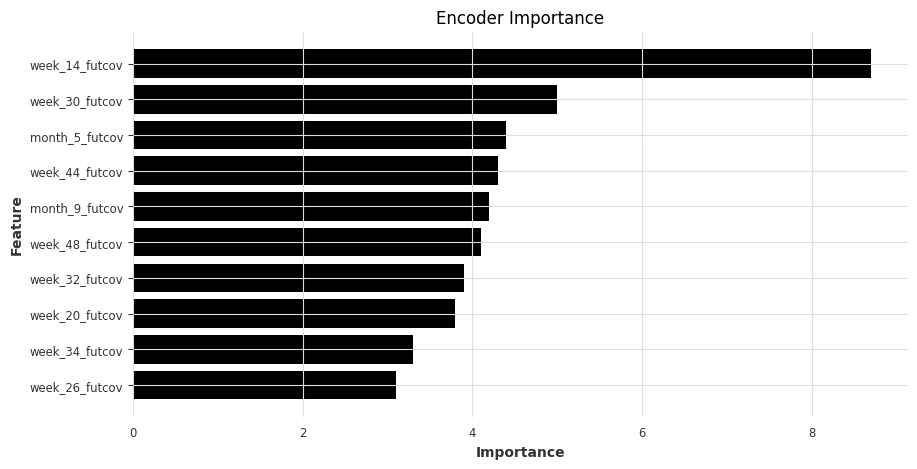

In [29]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(data=explainer._encoder_importance.melt().sort_values(by='value').tail(10), y='variable', width='value')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Encoder Importance')
plt.show()

### Decoder Importance

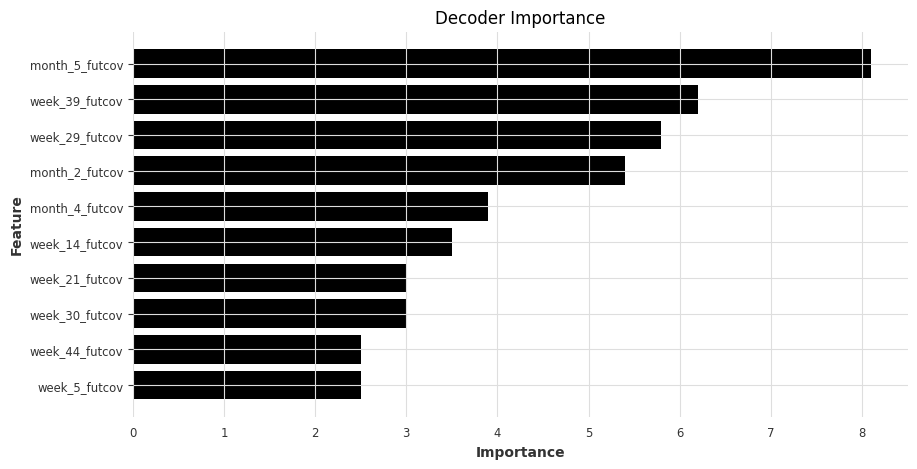

In [30]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(data=explainer._decoder_importance.melt().sort_values(by='value').tail(10), y='variable', width='value')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Decoder Importance')
plt.show()

### Static Cov Importance

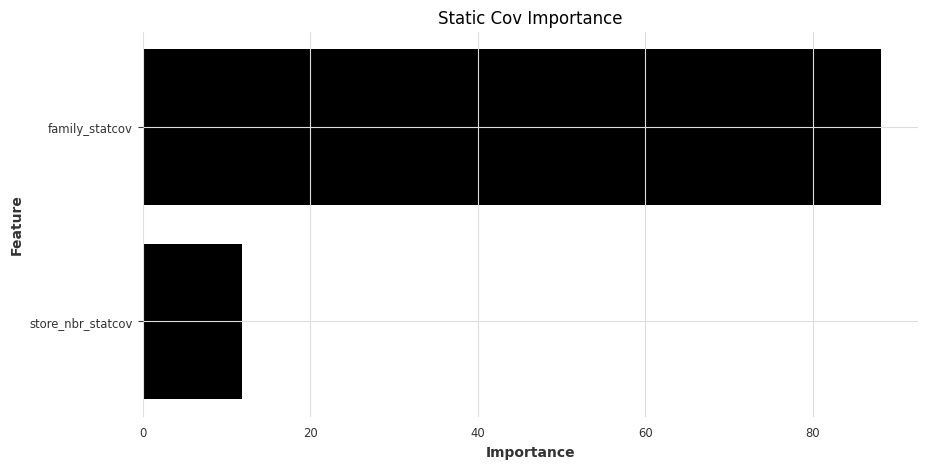

In [31]:
plt.rcParams["figure.figsize"] = (10,5)
plt.barh(data=explainer._static_covariates_importance.melt().sort_values(by='value').tail(10), y='variable', width='value')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Static Cov Importance')
plt.show()

### Time Importance

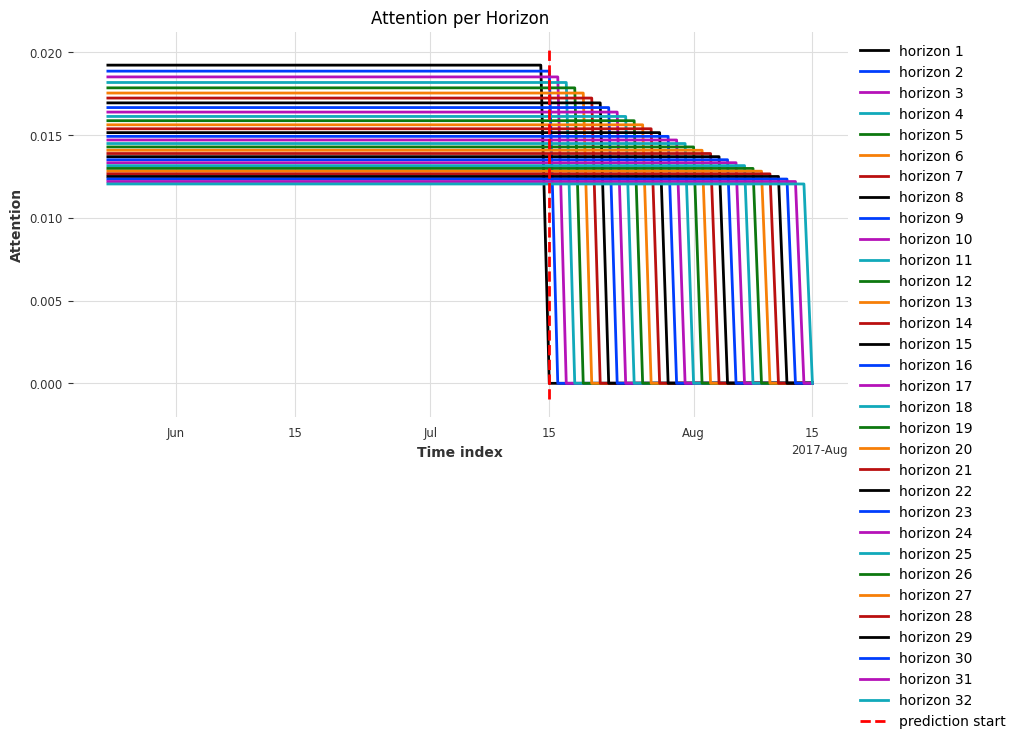

<Axes: title={'center': 'Attention per Horizon'}, xlabel='Time index', ylabel='Attention'>

In [32]:
explainer.plot_attention(explainability_result, plot_type="all", show_index_as='time')